In [1]:
"""
Here we train and evaluate our final model and that of liu and lam, both for the denoising and deconvolution problems, 
and compare the results obtained. In this notebook we use images affected by noise level 6.
"""

# PACKAGES
import os

# Math and data
import math
import numpy as np
import h5py
import random
import pandas as pd
#import scipy

# Image processing and plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from matplotlib import colors
import cv2

# Astropy
from astropy.io import fits
from astropy.visualization import astropy_mpl_style

# Machine learning
import sklearn as sk
from skimage.metrics import structural_similarity as ssim

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Add
from tensorflow.python.framework import ops
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Model

# Local functions
from TFMPackage import architectures_V2
from TFMPackage import train_utils
from TFMPackage import plot_utils
from astropy.visualization import astropy_mpl_style
from sklearn.model_selection import train_test_split

# Denoising

In [2]:
# NOISE LEVEL SELECTION
noise_level = "6"

In [3]:
# DATA LOADING
current_dir=os.getcwd()
hdul_X = fits.open(current_dir + "\\data\\final\\multi_PSF_Noise_L" + noise_level + ".fits")
hdul_Y = fits.open(current_dir + "\\data\\final\\multi_PSF_noNoise.fits")

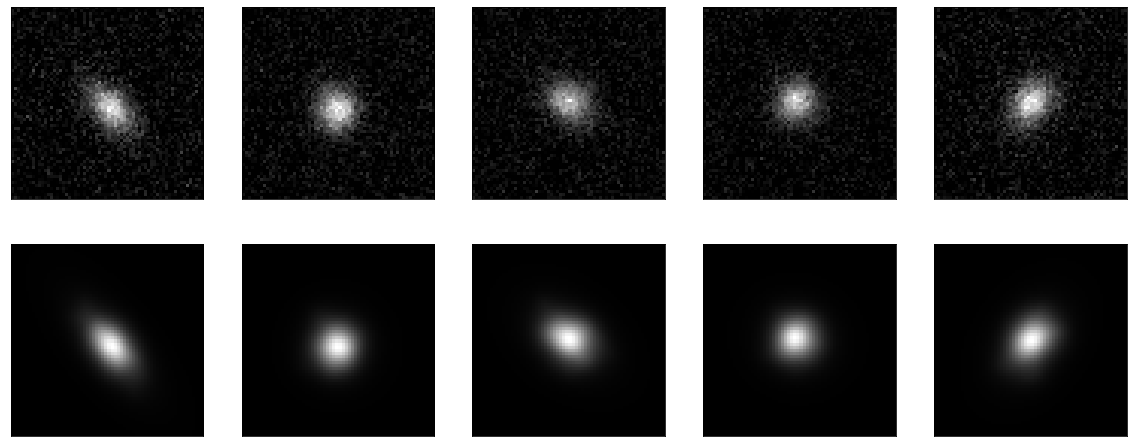

In [4]:
# DATA PREPROCESSING

# Convert to Array and remove the last row and column of the image
X = np.array([hdul_X[i].data[0:-1, 0:-1].clip(0.) for i in range(len(hdul_X))]) 
y = np.array([hdul_Y[i].data[0:-1, 0:-1] for i in range(len(hdul_Y))])

# Normalization
maxim = np.max([X,y])
X = train_utils.preprocess(X, dim=1, max_value = maxim)
y = train_utils.preprocess(y, dim=1, max_value = maxim)

# Split in 70% training 20% validation and 10% test
X_pretrain, X_test, y_pretrain, y_test = train_test_split(X, y, test_size=0.10)
X_train, X_val, y_train, y_val = train_test_split(X_pretrain, y_pretrain, test_size=0.22)

# Model input shape
input_shape = (64, 64, 1)

# Some examples of training samples with and without noise
plot_utils.display(X_train, y_train, n = 5)

In [5]:
# TRAINNING

batch_size = 128
optimizer = "rmsprop"
loss = "mse"
epochs = 40
save_dir = train_utils.create_directory(problem_type = "poisson", noise_level = "level_" + noise_level)


model_save_path_original = save_dir + "\\model_original.h5"
history_save_path_original = save_dir + "\\history_original.npy"
model_original = architectures_V2.Liu_Lam_Original(input_shape).getModel()
[model_original_trained, history_original] = train_utils.train_model(model_original, X_train, y_train, X_val, y_val, 
                                                                     model_save_path_original, history_save_path_original,
                                                                     input_shape = (64, 64, 1), optimizer=optimizer,
                                                                     epochs = epochs, batch_size = batch_size, loss=loss)

model_save_path_final = save_dir + "\\model_final.h5"
history_save_path_final = save_dir + "\\history_final.npy"
model_final = architectures_V2.My_model(input_shape).getModel()
[model_final_trained, history_final] = train_utils.train_model(model_final, X_train, y_train, X_val, y_val, 
                                                                     model_save_path_final, history_save_path_final,
                                                                     input_shape = (64, 64, 1), optimizer=optimizer,
                                                                     epochs = epochs, batch_size = batch_size, loss=loss)


Epoch 1/40
45/45 [==============================] - 27s 577ms/step - loss: 5.9989e-04 - val_loss: 1.9241e-04
Epoch 2/40
45/45 [==============================] - 27s 601ms/step - loss: 1.6096e-04 - val_loss: 1.3845e-04
Epoch 3/40
45/45 [==============================] - 28s 613ms/step - loss: 1.2677e-04 - val_loss: 1.1136e-04
Epoch 4/40
45/45 [==============================] - 27s 609ms/step - loss: 1.0710e-04 - val_loss: 9.9536e-05
Epoch 5/40
45/45 [==============================] - 28s 622ms/step - loss: 9.3876e-05 - val_loss: 8.9127e-05
Epoch 6/40
45/45 [==============================] - 29s 636ms/step - loss: 8.6391e-05 - val_loss: 7.7081e-05
Epoch 7/40
45/45 [==============================] - 28s 630ms/step - loss: 7.9593e-05 - val_loss: 7.3873e-05
Epoch 8/40
45/45 [==============================] - 28s 627ms/step - loss: 7.5128e-05 - val_loss: 8.0006e-05
Epoch 9/40
45/45 [==============================] - 32s 702ms/step - loss: 7.1295e-05 - val_loss: 6.8075e-05
Epoch 10/40
45/45 [

In [6]:
# TEST
condition = False
print('\n---------------------------------------------LIU LAM ORIGINAL-------------------------------------------------\n')
train_utils.test_model(model_original, X_val, y_val, n = 5, plot_examples = condition)
print('\n------------------------------------------------MY MODEL------------------------------------------------------\n')
train_utils.test_model(model_final, X_val, y_val, n = 5, plot_examples = condition)


---------------------------------------------LIU LAM ORIGINAL-------------------------------------------------


Average MSE between reference and with aberrations images:  8772595.83582715

Average MSE between reference and corrected images:  181236.5133749184

Average PSNR between reference and with aberrations images:  26.898184861866802

Average PSNR between reference and corrected images:  43.74700908893129

Average SSIM between reference and with aberrations images:  0.2083556826012071

Average SSIM between reference and corrected images:  0.9305932462127068

------------------------------------------------MY MODEL------------------------------------------------------


Average MSE between reference and with aberrations images:  8772595.83582715

Average MSE between reference and corrected images:  115620.73943772161

Average PSNR between reference and with aberrations images:  26.898184861866802

Average PSNR between reference and corrected images:  45.699108650074436

Average 

# PSF

In [7]:
# NOISE LEVEL SELECTION
noise_level = "6"

In [8]:
# DATA LOADING
current_dir=os.getcwd()
hdul_X = fits.open(current_dir + "\\data\\final\\multi_PSF_Noise_L" + noise_level + ".fits")
hdul_Y = fits.open(current_dir + "\\data\\final\\multi_noPSF_noNoise.fits")

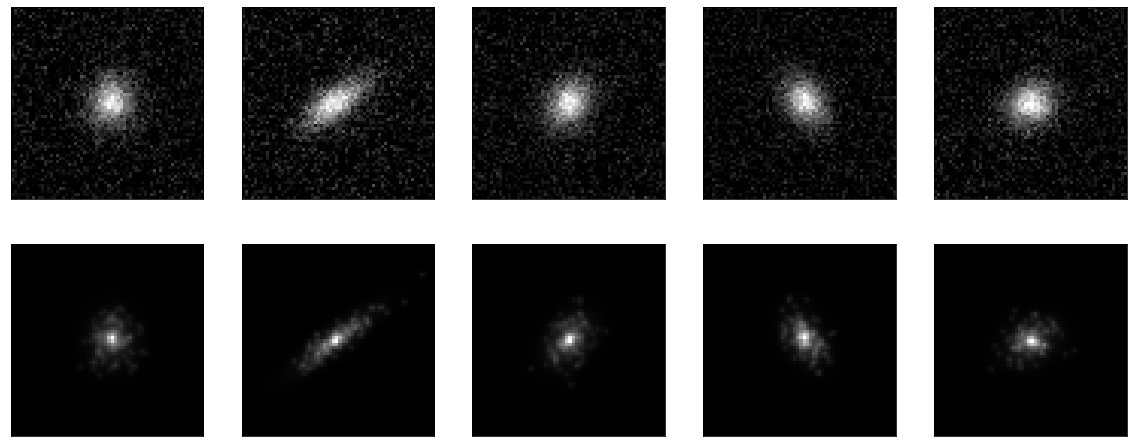

In [9]:
# DATA PREPROCESSING

# Convert to Array and remove the last row and column of the image
X = np.array([hdul_X[i].data[0:-1, 0:-1].clip(0.) for i in range(len(hdul_X))]) 
y = np.array([hdul_Y[i].data[0:-1, 0:-1] for i in range(len(hdul_Y))])

# Normalization
maxim = np.max([X,y])
X = train_utils.preprocess(X, dim=1, max_value = maxim)
y = train_utils.preprocess(y, dim=1, max_value = maxim)

# Split in 70% training 20% validation and 10% test
X_pretrain, X_test, y_pretrain, y_test = train_test_split(X, y, test_size=0.10)
X_train, X_val, y_train, y_val = train_test_split(X_pretrain, y_pretrain, test_size=0.22)

# Model input shape
input_shape = (64, 64, 1)

# Some examples of training samples with and without noise
plot_utils.display(X_train, y_train, n = 5)

In [10]:
# TRAINNING

batch_size = 128
optimizer = "rmsprop"
loss = "mse"
epochs = 40
save_dir = train_utils.create_directory(problem_type = "PSF", noise_level = "level_" + noise_level)


model_save_path_original = save_dir + "\\model_original.h5"
history_save_path_original = save_dir + "\\history_original.npy"
model_original = architectures_V2.Liu_Lam_Original(input_shape).getModel()
[model_original_trained, history_original] = train_utils.train_model(model_original, X_train, y_train, X_val, y_val, 
                                                                     model_save_path_original, history_save_path_original,
                                                                     input_shape = (64, 64, 1), optimizer=optimizer,
                                                                     epochs = epochs, batch_size = batch_size, loss=loss)

model_save_path_final = save_dir + "\\model_final.h5"
history_save_path_final = save_dir + "\\history_final.npy"
model_final = architectures_V2.My_model(input_shape).getModel()
[model_final_trained, history_final] = train_utils.train_model(model_final, X_train, y_train, X_val, y_val, 
                                                                     model_save_path_final, history_save_path_final,
                                                                     input_shape = (64, 64, 1), optimizer=optimizer,
                                                                     epochs = epochs, batch_size = batch_size, loss=loss)

Epoch 1/40
45/45 [==============================] - 28s 594ms/step - loss: 8.2074e-04 - val_loss: 6.6356e-04
Epoch 2/40
45/45 [==============================] - 26s 588ms/step - loss: 4.1492e-04 - val_loss: 2.1955e-04
Epoch 3/40
45/45 [==============================] - 26s 586ms/step - loss: 2.0117e-04 - val_loss: 1.8412e-04
Epoch 4/40
45/45 [==============================] - 27s 598ms/step - loss: 1.7791e-04 - val_loss: 1.5855e-04
Epoch 5/40
45/45 [==============================] - 26s 586ms/step - loss: 1.6549e-04 - val_loss: 1.5486e-04
Epoch 6/40
45/45 [==============================] - 27s 596ms/step - loss: 1.5691e-04 - val_loss: 1.5910e-04
Epoch 7/40
45/45 [==============================] - 27s 604ms/step - loss: 1.4928e-04 - val_loss: 1.4751e-04
Epoch 8/40
45/45 [==============================] - 27s 601ms/step - loss: 1.4452e-04 - val_loss: 1.4835e-04
Epoch 9/40
45/45 [==============================] - 27s 597ms/step - loss: 1.4067e-04 - val_loss: 1.3353e-04
Epoch 10/40
45/45 [

In [11]:
# TEST
condition = False
print('\n---------------------------------------------LIU LAM ORIGINAL-------------------------------------------------\n')
train_utils.test_model(model_original, X_val, y_val, n = 5, plot_examples = condition)
print('\n------------------------------------------------MY MODEL------------------------------------------------------\n')
train_utils.test_model(model_final, X_val, y_val, n = 5, plot_examples = condition)


---------------------------------------------LIU LAM ORIGINAL-------------------------------------------------


Average MSE between reference and with aberrations images:  2658192.0082747536

Average MSE between reference and corrected images:  465091.96163415315

Average PSNR between reference and with aberrations images:  32.083602595458856

Average PSNR between reference and corrected images:  39.65407774035106

Average SSIM between reference and with aberrations images:  0.42064193905483854

Average SSIM between reference and corrected images:  0.9368353968794235

------------------------------------------------MY MODEL------------------------------------------------------


Average MSE between reference and with aberrations images:  2658192.0082747536

Average MSE between reference and corrected images:  436066.31676652486

Average PSNR between reference and with aberrations images:  32.083602595458856

Average PSNR between reference and corrected images:  39.933940659324946

Av